# Seperating stock to forcast for certain dates depending on the product

In [1]:
%pip install nbformat


[notice] A new release of pip is available: 24.1.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
# import datasets and transformations (reusability purposes)
from IPython import get_ipython

get_ipython().run_line_magic('run', 'datasets.ipynb')

/var/folders/31/9bd8ksys1rzbjk8qs9scl95h0000gn/T/ipykernel_3558/3694211296.py:4: DtypeWarning: Columns (4,6,20,50,52) have mixed types. Specify dtype option on import or set low_memory=False.
  products_s = pd.read_csv('../datasets/stock_forecasting/2022-2025/[LT] Products [STOCK].txt', sep='\t', header=0) # stock
/var/folders/31/9bd8ksys1rzbjk8qs9scl95h0000gn/T/ipykernel_3558/3694211296.py:5: DtypeWarning: Columns (5,48) have mixed types. Specify dtype option on import or set low_memory=False.
  tickets_c_i = pd.read_csv('../datasets/stock_forecasting/2022-2025/[LT] Tickets [CUSTOM] [ITEMS].txt', sep='\t', header=0) # customer order items
/var/folders/31/9bd8ksys1rzbjk8qs9scl95h0000gn/T/ipykernel_3558/3694211296.py:6: DtypeWarning: Columns (43,57,104,139,210,244,251,289,293,310,321,324,326,344,348) have mixed types. Specify dtype option on import or set low_memory=False.
  tickets_c_m = pd.read_csv('../datasets/stock_forecasting/2022-2025/[LT] Tickets [CUSTOM] [MAIN].txt', sep='\t', h

-------------- Product [STOCK] ----------------
   Adhesive  Alternate  Available  BackOrdered Box_Size  CaseQty Color  \
0       NaN        NaN          0            0      NaN      NaN   NaN   
1       NaN        NaN          0            0      NaN      NaN   NaN   
2       NaN        NaN          0            0      NaN      NaN   NaN   
3       NaN        NaN          0            0      NaN      NaN   NaN   
4       NaN        NaN          0            0      NaN      NaN   NaN   

   Commission   Cost  Currency_ExchangeRate  ...  SupplierName  SupplierNo  \
0           0   0.00                      0  ...           NaN         NaN   
1           0   0.00                      0  ...           NaN         NaN   
2           0   0.00                      0  ...           NaN         NaN   
3           0   0.00                      0  ...           NaN         NaN   
4           0  49.11                      0  ...           NaN         NaN   

  SupplierNotes SupplierPartNo Tag Tot

/var/folders/31/9bd8ksys1rzbjk8qs9scl95h0000gn/T/ipykernel_3558/694328055.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data['OrderDate'] = pd.to_datetime(merged_data['OrderDate'], errors='coerce')
/var/folders/31/9bd8ksys1rzbjk8qs9scl95h0000gn/T/ipykernel_3558/694328055.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data['OrderDate'] = pd.to_datetime(merged_data['OrderDate'], errors='coerce')
/var/folders/31/9bd8ksys1rzbjk8qs9scl95h0000gn/T/ipykernel_3558/694328055.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To e

In [4]:
# create solution to add each first three unique values of the column 'ProductNumber' to a list
products_by_customer = set()

# loop through all product numbers
for index, row in product_sales.iterrows():
    product = row['ProductNumber']
    for i in range(len(product) - 2):
        customer_code = product[i:i+3]  # get the first three characters of the product number

        # add the customer code to the set
        products_by_customer.add(customer_code)

        # create a list for each customer code / if it exists, add it to the existing customer code list
        if f'custom_code_{customer_code}' in locals():
            locals()[f'custom_code_{customer_code}'].append(row.to_dict())
        else:
            locals()[f'custom_code_{customer_code}'] = [row.to_dict()]

print(f"All custom codes for existing products: \n{products_by_customer} \n ------------------------------------")

# Example to print one of the custom code lists
if 'custom_code_FRE' in locals():
    print(f"Records for custom code FRE: \n{locals()['custom_code_FRE']}")

All custom codes for existing products: 
{'480', '498', 'LB-', '21V', 'THN', '281', '042', '472', 'POS', '60U', 'UI-', '82Y', '05X', '970', '46Y', '09T', '854', '06W', '83W', '795', '842', '659', '96Z', '129', '379', '336', '429', 'RU-', '71Y', '541', 'EX-', '10S', 'ED-', 'TK-', '667', 'HOL', '20W', '732', '89X', 'LS-', '036', '978', '31Y', '412', '008', '805', '32Q', '620', '90Z', 'RW-', '49W', '880', '50V', '15Z', '93Z', '82Z', 'OH-', '072', '646', 'ORC', 'WIN', '17Z', 'A-T', '345', '206', '93X', 'ECS', '478', '75Y', '750', '264', '608', 'ODO', '69Y', '62X', 'EO-', '967', '331', '85V', '800', '171', '127', '791', '23P', '4Z-', 'VNF', '898', '96U', '32-', '322', '-04', '222', 'CMX', '900', '79Q', 'GOO', 'SS-', 'HF-', '28Y', '13W', 'LA-', 'TOG', '47W', 'CF-', 'ELS', '40V', '96X', '43R', '095', '590', 'TH-', 'DJB', '-F2', '502', '27Q', '26-', '100', '80W', '015', '479', '53X', 'TA-', '381', '48U', '31Z', '150', '466', '887', '65Y', '126', '711', '233', '58X', '95Z', '54V', '27Y', '275',

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# define the features and target variable from 'product_sales'
# convert custom_code_FRE to a DataFrame
custom_code_df = pd.DataFrame(custom_code_ALB)

In [6]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

df = custom_code_df.copy()

# Define feature set (X) and target variable (y)
features = ['ProductNumber', 'order_month']
target = 'OrderQuantity'

X = df[features]
y = df[target]

# One-Hot Encoding for categorical features
categorical_features = ['ProductNumber',]
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Preprocessor (keeps numerical features as is)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', encoder, categorical_features)  # One-hot encode categorical features
    ], remainder='passthrough'
)

# Transform the features
X_transformed = preprocessor.fit_transform(X)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [8]:
from sklearn.ensemble import RandomForestRegressor
import sys
sys.path.append('../src')
from model_utils import find_best_hyperparameters, param_grids, evaluate_model

# train the model with scaled features (Random Forest Regressor)
rf = RandomForestRegressor()
rf_params = find_best_hyperparameters(rf, param_grids(rf.__class__.__name__), X_train_scaled, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, 

In [9]:
rf = RandomForestRegressor(**rf_params)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_val_scaled)

In [13]:
evaluate_model(rf, X_train_scaled, y_train)
print('--------------------------------------------')

Evaluating model...
Model: RandomForestRegressor
Mean Absolute Error (MAE): 84373.9312
Mean Squared Error (MSE): 34786522416.7644
Root Mean Squared Error (RMSE): 186511.4538
R-squared (R²): 0.5460
--------------------------------------------


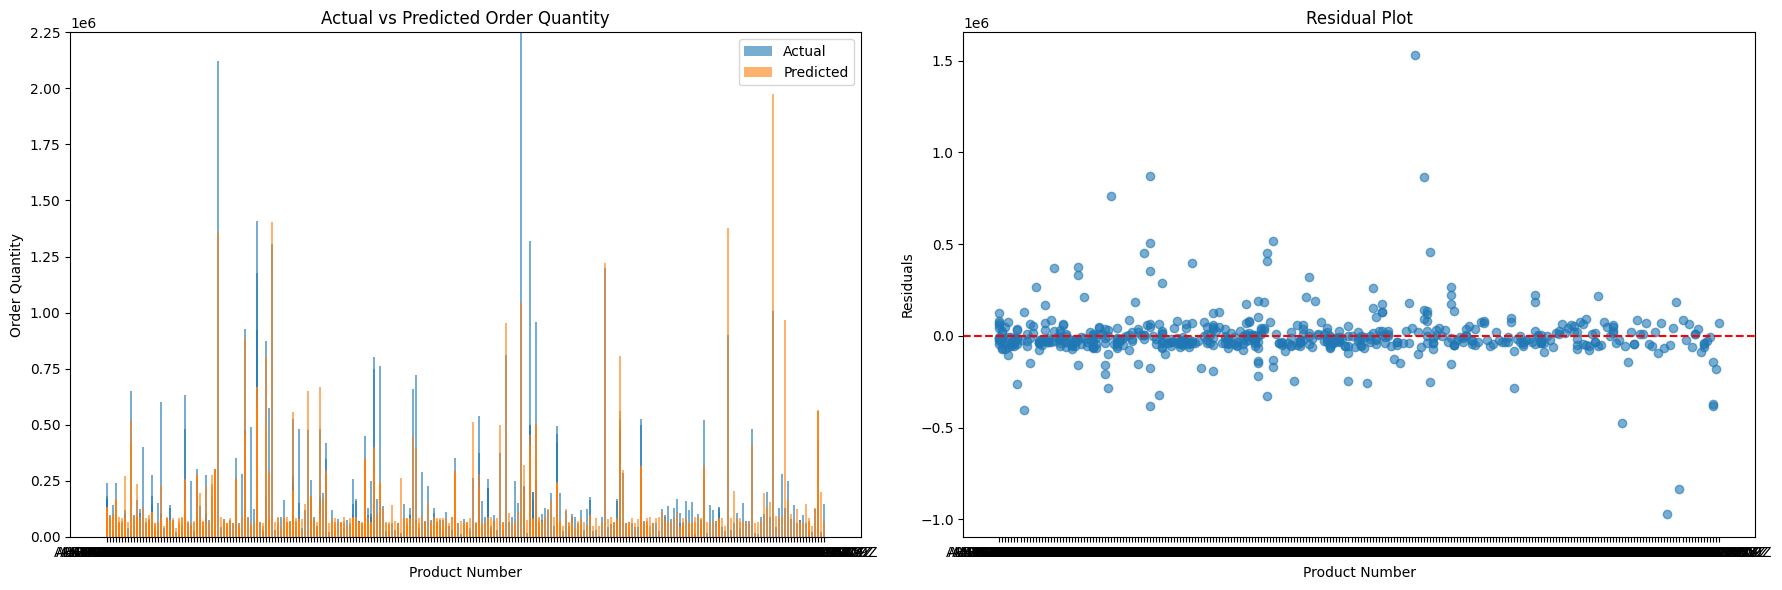

In [11]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot the bar plot to compare the actual and predicted values
axes[0].bar(product_sales.loc[y_val.index, 'ProductNumber'], y_val, label='Actual', alpha=0.6)
axes[0].bar(product_sales.loc[y_val.index, 'ProductNumber'], y_pred_rf, label='Predicted', alpha=0.6)
axes[0].set_xlabel('Product Number')
axes[0].set_ylabel('Order Quantity')
axes[0].set_title('Actual vs Predicted Order Quantity')
axes[0].set_ylim(0, 2250000)
axes[0].legend()

# Plot the residual plot
residuals = y_val - y_pred_rf
axes[1].scatter(product_sales.loc[y_val.index, 'ProductNumber'], residuals, alpha=0.6)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Product Number')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')

# Show the plots
plt.tight_layout()
plt.show()

In [12]:
# plot a confusion matrix to show the performance of the model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# create a confusion matrix
confusion_matrix(y_val, y_pred_rf)

# plot the confusion matrix
plot_confusion_matrix(rf, X_val_scaled, y_val, cmap='Blues', normalize='true')
plt.show()

ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/metrics/__init__.py)